# Kuramoto Model

[Click here to view the assignment PDF](https://www.lptmc.jussieu.fr/user/viot/COURS/homework2.pdf)

We propose to study by numerical simulation the **paradigmatic model of synchronization**, the Kuramoto model. Introduced by Kuramoto in 1975, it illustrates the propensity of coupled oscillators to evolve towards a collective oscillation when the coupling exceeds a critical value. After 35 years, many situations have been considered. In this homework, we restrict ourselves to some fundamental properties.

You can use any programming language for your code. The simulations are not very demanding; if you use Python with NumPy and avoid unnecessary loops, a typical execution time should be close to 2 minutes on a laptop, and less than 10 minutes in the final part of the homework.

We consider \(N\) one-dimensional rotors arranged on a ring. The equations of motion are:

$$
\dot{\theta}_i \;=\; \omega_i 
\;+\; \sum_{j=1}^N \frac{K}{N}\,\sin\bigl(\theta_j - \theta_i\bigr),
$$

where $\theta_i$ and $\omega_i$ are the phase and natural frequency of the $i$-th rotor. The parameter $K$ is the coupling strength and the factor $\tfrac{1}{N}$ ensures the model is well-defined in the thermodynamic limit. The frequencies $\{\omega_i\}$ are drawn from a centered distribution.

To visualize the collective dynamics, we introduce the **complex order parameter**:

$$
r(t)\,e^{i\,\Psi(t)} 
\;=\; \frac{1}{N} \sum_{i=1}^N e^{i\,\theta_i(t)}.
$$

---

1. **Rewrite the equations of motion**  

   Show that the equations of motion can be rewritten as  

   $$
   \dot{\theta}_i 
   \;=\; \omega_i 
   \;+\; K\,r\,\sin\bigl(\Psi - \theta_i\bigr)
   $$

---

*Note:* SciPy provides the function `solve_ivp` for ODE integration and can automatically take advantage of parallelization.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --------------------------
# 1) Define parameters
# --------------------------
N = 10
tmax = 100.0
t_eval = np.linspace(0, tmax, 1000)   # times at which we want the solution

# Frequencies drawn from a centered Gaussian, e.g. mean=0, std=1
np.random.seed(123)  # for reproducible results
omega = np.random.normal(loc=0.0, scale=1.0, size=N)

# Initial phases from uniform([-pi, pi])
theta0 = np.random.uniform(-np.pi, np.pi, N)

def kuramoto_equations(t, theta, omega, K):
    """
    dtheta_i/dt = omega_i + (K/N) * sum_j sin(theta_j - theta_i)
    """
    N = len(theta)
    r_psi = np.sum(np.exp(1j * theta)) / N  # Complex order parameter
    r = np.abs(r_psi)  # Magnitude of the order parameter
    psi = np.angle(r_psi)  # Phase of the order parameter
    dtheta_dt = omega + K * r * np.sin(psi - theta)
    return dtheta_dt

# Function to run a single simulation for given K
def run_kuramoto(K):
    sol = solve_ivp(fun=lambda t, th: kuramoto_equations(t, th, omega, K),
                    t_span=(0, tmax),
                    y0=theta0,
                    t_eval=t_eval,
                    method='RK45',  # adaptive RK
                    rtol=1e-8, atol=1e-8)
    return sol

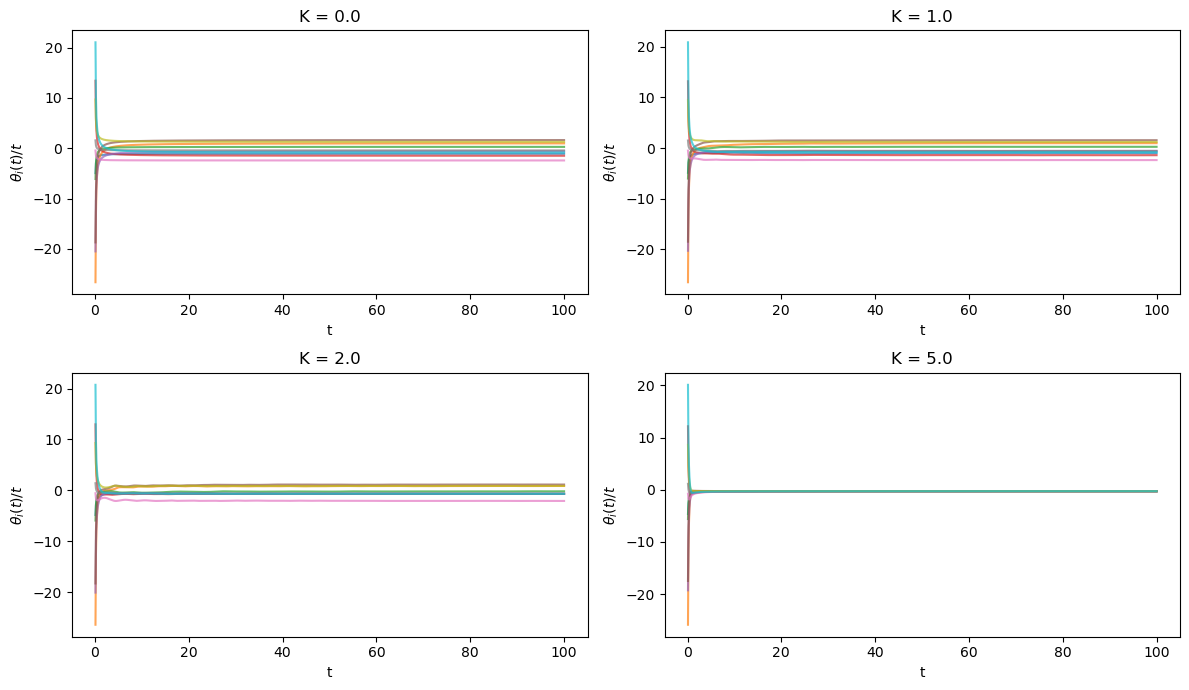

In [5]:
# --------------------------
# 2) Run for different K
# --------------------------

K_values = [0.0, 1.0, 2.0, 5.0]

fig, axs = plt.subplots(2, 2, figsize=(12,7))
axs = axs.ravel()

for i, K in enumerate(K_values):
    sol = run_kuramoto(K)
    t = sol.t
    theta_t = sol.y  # shape (N, len(t))
    
    # Compute theta_i(t)/t for i=1..N
    # avoid dividing by zero at t=0 => shift the index or handle t=0 carefully
    # here we skip the first time point t[0] = 0
    t_nonzero = t[1:]
    theta_div_t = theta_t[:, 1:] / t_nonzero
    
    # Plot results for each oscillator
    for n in range(N):
        axs[i].plot(t_nonzero, theta_div_t[n, :], label=f"Osc {n+1}", alpha=0.7)
    
    axs[i].set_title(f"K = {K}")
    axs[i].set_xlabel("t")
    axs[i].set_ylabel(r"$\theta_i(t)/t$")

plt.tight_layout()
plt.show()
fig.savefig("kuramoto_plots_allK.png")

**Large Number of Rotors ($N = 100$)**

One searches to obtain results for a large number of rotors, here chosen as $N = 100$. Modify the previous code to **compute** the *absolute value* of the order parameter $r$ of the system *as a function of time*. To suppress spurious oscillations, once the random frequencies are selected, **subtract** their *mean value* so that the average frequency remains zero.on.

---

**Table 1** shows the *number of particles* ($N$) and *number of independent simulations* ($N_{\mathrm{rep}}$) to be performed:

| $N$    | $N_{\mathrm{rep}}$ |
|--------|---------------------|
| 100    | 300                 |
| 500    | 100                 |
| 2000   | 50                  |
| 5000   | 30                  |
| 15000  | 10                  |

---

After ensuring the mean frequency is zero, **plot** the order parameter $r$ as a function of time for different values of the coupling strength $K$ between 1 and 2. (Take 25 values of $K$ evenly spaced in theinterval $[1, 2]$.)


In [7]:
def simulate_for_K(K, N, Nrep=10):
    """
    Fait Nrep réalisations indépendantes, retourne la moyenne de r(t_final)
    (ou plusieurs instants) selon les besoins.
    """
    r_final_vals = []
    for _ in range(Nrep):
        # 1) Génération des fréquences
        omega = np.random.normal(0.0, 1.0, N)
        omega -= np.mean(omega)  # centrage
        
        # 2) Phases initiales aléatoires
        theta0 = np.random.uniform(-np.pi, np.pi, N)
        
        # 3) Intégration
        sol = solve_ivp(
            lambda t,th: kuramoto_equations(t, th, omega, K),
            t_span=(0, 50),  # ou plus grand si besoin
            y0=theta0,
            t_eval=[50],     # on ne sauvegarde que la fin
            method='RK45'
        )
        
        theta_final = sol.y[:, -1]
        # 4) Calcul de r(t_final)
        real_part = np.mean(np.cos(theta_final))
        imag_part = np.mean(np.sin(theta_final))
        r_final = np.sqrt(real_part**2 + imag_part**2)
        r_final_vals.append(r_final)
    
    return np.mean(r_final_vals)  # moyenne sur Nrep

100, Done!
500, Done!
2000, Done!
5000, Done!
15000, Done!


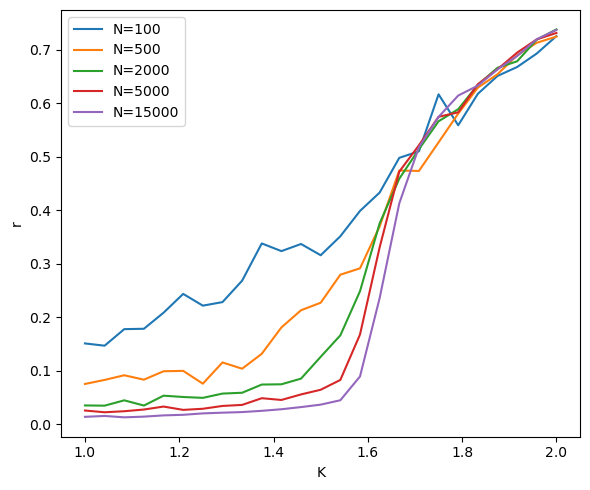

In [8]:
# -----------
N_list = [100, 500, 2000, 5000, 15000]
K_values = np.linspace(1.0, 2.0, 25)

plt.figure(figsize=(6,5))

for N in N_list:
    r_means = []
    for K in K_values:
        r_means.append(simulate_for_K(K, N, Nrep=30))
    plt.plot(K_values, r_means, label=f'N={N}')
    print(f"{N}, Done!")

plt.xlabel('K')
plt.ylabel('r')
plt.legend()
plt.tight_layout()
plt.savefig("kuramoto_stationary_all_N.png")
plt.show()

**In order to suppress fluctuations due to the disorder, it is necessary to take an average of the order parameter over 100 independent simulations.** 

After a first relaxation time which is less than 50, the order parameter $\mathbf{r}$ oscillates for a long time. To save computer time, one **estimates** the *stationary value* of the order parameter by **averaging** $r$ on the interval $[50, 100]$ for each simulation. 

By performing $N_{\mathrm{rep}}$ independent simulations, obtain **mean values** of the stationary order parameter $\bar{r}$ for each value of $K$. Finally, **plot** $\bar{r}$ *as a function of* $K$.

In [10]:
def run_simulation(N, K, tmax=100, t_relax=50):
    """
    Runs ONE realization of the Kuramoto model for given N, K.
    Returns the time array, the entire solution theta(t),
    and the order parameter r(t).
    """
    # 1) Generate random frequencies, subtract mean
    omega = np.random.normal(0.0, 1.0, N)
    omega -= np.mean(omega)
    
    # 2) Random initial phases in [-pi, pi]
    theta0 = np.random.uniform(-np.pi, np.pi, N)
    
    # 3) Integrate up to tmax (e.g. 100)
    t_eval = np.linspace(0, tmax, 2000)  # 2000 points for smooth sampling
    sol = solve_ivp(lambda t, th: kuramoto_equations(t, th, omega, K),
                    t_span=(0, tmax),
                    y0=theta0,
                    t_eval=t_eval,
                    method='RK45')
    
    theta_t = sol.y        # shape: (N, len(t_eval))
    t_arr   = sol.t        # shape: (len(t_eval),)
    
    # 4) Compute r(t) = |(1/N) * sum_j exp(i*theta_j(t))|
    cos_mean = np.mean(np.cos(theta_t), axis=0)  # average over j
    sin_mean = np.mean(np.sin(theta_t), axis=0)
    r_t = np.sqrt(cos_mean**2 + sin_mean**2)
    
    return t_arr, theta_t, r_t

def estimate_stationary_r(N, K, Nrep=100, tmax=100, t_relax=50):
    """
    Runs Nrep independent simulations for given (N, K),
    averages r(t) over [t_relax, tmax] in each simulation,
    and returns the mean of those averages.
    """
    r_values = []  # will hold the average r for each simulation
    for _ in range(Nrep):
        t_arr, theta_t, r_t = run_simulation(N, K, tmax, t_relax)
        # Identify indices where t >= t_relax
        mask = t_arr >= t_relax
        # Average r(t) from t_relax up to tmax
        r_avg = np.mean(r_t[mask])
        r_values.append(r_avg)
    return np.mean(r_values)

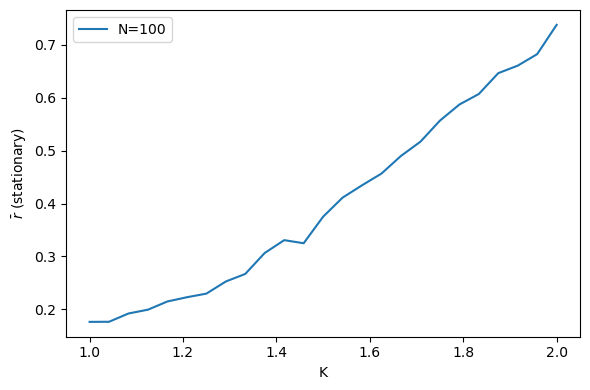

In [11]:
N = 100  # or set up a list of N values if you want to compare
K_vals = np.linspace(1.0, 2.0, 25)  # 25 values of K
Nrep = 100  # number of independent realizations

r_stationary = []

for K in K_vals:
    r_stat = estimate_stationary_r(N, K, Nrep=Nrep, tmax=100, t_relax=50)
    r_stationary.append(r_stat)

# Plot final r vs K
plt.figure(figsize=(6,4))
plt.plot(K_vals, r_stationary, '-', label=f"N={N}")
plt.xlabel("K")
plt.ylabel(r"$\bar{r}$ (stationary)")
plt.legend()
plt.tight_layout()
plt.savefig("kuramoto_stationary_r_vs_K_with_Nrep.png")
plt.show()

Run the previous code for **different system sizes** $N$ and for **several simulations** $N_{\mathrm{rep}}$. Refer to **Table 1** for the five simulations to be performed:

- $N = 100$, $N_{\mathrm{rep}} = 300$
- $N = 500$, $N_{\mathrm{rep}} = 100$
- $N = 2000$, $N_{\mathrm{rep}} = 50$
- $N = 5000$, $N_{\mathrm{rep}} = 30$
- $N = 15000$, $N_{\mathrm{rep}} = 10$

After running these simulations:

1. **Estimate** the stationary order parameter $\bar{r}$ for each run by discarding the initial relaxation time (for instance, up to $t = 50$) and averaging $r(t)$ from $t = 50$ to $t = 100$.
2. **Average** these stationary values $\bar{r}$ over the $N_{\mathrm{rep}}$ independent realizations of the random frequencies.
3. **Plot** the resulting mean stationary values $\bar{r}$ as a function of the coupling strength $K$. You should obtain a figure **similar to Fig. 1** in your assignment, illustrating the onset of synchronization.

---

**Thermodynamic Limit and the Critical Coupling**

One can show that, in the **thermodynamic limit**, the Kuramoto model undergoes a **second-order phase transition** with a critical coupling strength

$$
K_c \;=\; \frac{2}{\pi \, g(0)},
$$

where $g(0)$ is the value of the frequency probability distribution $g(\omega)$ at its center, $\omega = 0$.

- For instance, if the frequencies are drawn from a **Gaussian** distribution $\mathcal{N}(0, 1)$, then $g(0) = 1/\sqrt{2\pi}$. Substituting yields

$$
K_c \;=\; \frac{2}{\pi} \,\biggl(\frac{1}{g(0)}\biggr)
     \;=\; \frac{2\sqrt{2\pi}}{\pi}
     \;\approx\; 1.60.
$$

In your simulations, **plot a vertical line** at this theoretical $K_c$ to highlight the approximate location of the phase transition. Even if more extensive simulations are necessary to precisely extract critical exponents, you should observe that the **numerical results** for large $N$ are **compatible** with this critical coupling in the thermodynamic limit.

In [13]:
def run_kuramoto_simulation(N, K, tmax=100.0, t_relax=50.0):
    """
    Runs a single Kuramoto simulation for (N, K).
    Returns the time array, the entire theta(t), and r(t).
    """
    # 1) Frequencies (Gaussian(0,1)), subtract mean
    omega = np.random.normal(0.0, 1.0, N)
    omega -= np.mean(omega)
    
    # 2) Random initial phases
    theta0 = np.random.uniform(-np.pi, np.pi, N)
    
    # 3) Integrate from 0 to tmax
    t_eval = np.linspace(0, tmax, 1000)  # sample times
    sol = solve_ivp(
        fun=lambda t, th: kuramoto_equations(t, th, omega, K),
        t_span=(0, tmax),
        y0=theta0,
        t_eval=t_eval,
        method='RK45'
    )
    
    # 4) Compute order parameter r(t)
    theta_t = sol.y  # shape: (N, len(t_eval))
    t_arr   = sol.t
    cos_mean = np.mean(np.cos(theta_t), axis=0)
    sin_mean = np.mean(np.sin(theta_t), axis=0)
    r_t = np.sqrt(cos_mean**2 + sin_mean**2)
    
    return t_arr, theta_t, r_t

def estimate_stationary_r(N, K, Nrep=100, tmax=100, t_relax=50):
    """
    Performs 'Nrep' independent simulations for (N,K).
    Returns the average of r(t) over [t_relax, tmax], then averaged across simulations.
    """
    r_averages = []
    for _ in range(Nrep):
        t_arr, theta_t, r_t = run_kuramoto_simulation(N, K, tmax, t_relax)
        # mask times >= t_relax
        mask = t_arr >= t_relax
        r_avg_over_time = np.mean(r_t[mask])
        r_averages.append(r_avg_over_time)
    # mean over all simulations
    return np.mean(r_averages)

100, Done!
500, Done!
2000, Done!
5000, Done!
15000, Done!


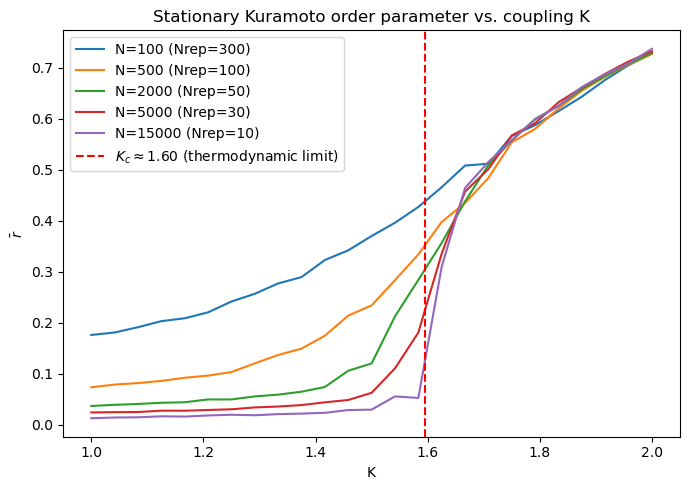

In [14]:
# ----------------------------------------------------
# Define the (N, Nrep) pairs as per in Table 1
# ----------------------------------------------------
N_values     = [100,    500,   2000,  5000,  15000]
Nrep_values  = [300,    100,    50,     30,     10]

# Define range of K: 25 values between 1 and 2
K_values = np.linspace(1.0, 2.0, 25)

# Prepare a figure for r(K) for each N
plt.figure(figsize=(7,5))

for N, Nrep in zip(N_values, Nrep_values):
    r_means = []
    for K in K_values:
        r_stat = estimate_stationary_r(N, K, Nrep=Nrep, tmax=100, t_relax=50)
        r_means.append(r_stat)
    
    # Plot r(K) for this particular N
    plt.plot(K_values, r_means, '-', label=f'N={N} (Nrep={Nrep})')
    print(f"{N}, Done!")

# (Optional) If your frequencies are Normal(0,1):
K_c = 2.0 * np.sqrt(2.0 * np.pi) / np.pi  # ~1.5958# Add vertical line at K_c

plt.axvline(x=K_c, color='red', linestyle='--', 
            label=r'$K_c \approx 1.60$ (thermodynamic limit)')

plt.xlabel('K')
plt.ylabel(r'$\bar{r}$')
plt.title("Stationary Kuramoto order parameter vs. coupling K")
plt.legend()
plt.tight_layout()
plt.savefig("kuramoto_stationary_all_N_with_Nrep.png")
plt.show()

**Interpretation**

- As $N$ increases, your numerical curves for $\bar{r}(K)$ will get *sharper* around $K_c$. In other words, the slope becomes steeper near the transition point.
- With truly large $N$, the transition becomes more *abrupt*, consistent with a second-order phase transition in the ideal thermodynamic limit.
- Even for finite $N$, the results tend to cluster around $K_c \approx 1.60$, showing that the simulation is indeed in agreement with the mean-field prediction.
